# Lab 2 - Astronomical Spectroscopy

## Import libraries and define common functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def centroid(arr, bounds=None): # returns the centroid index for an array with optional bounds for computing the centroid
    if bounds is None: # computes centroid over the entire array
        return sum(range(len(arr)) * arr) / sum(arr)
    else: # computes centroid over the subset of the array within the given bounds
        arrBound = arr[bounds[0]:bounds[1]]
        return sum(range(len(arrBound)) * arrBound) / sum(arrBound) + bounds[0]

def leastSquaresFit(x, y): # computes the slope and intercept of a least squares regression line fitting the input data
    if len(x) != len(y): # raises an error if the arrays are not the same length
        raise ValueError('x and y must be the same size')
    else:
        # Construct the matrices
        ma = np.array([[np.sum(x**2), np.sum(x)], [np.sum(x), len(x)]])
        mc = np.array([[np.sum(x*y)], [np.sum(y)]])

        # Compute the gradient and intercept
        mai = np.linalg.inv(ma) # inverts matrix ma
        md = np.dot(mai,mc) # matrix multiply is dot

        return md[0,0], md[1,0]

## Data Read-in

Because there is no logical order to the elements, an array probably doesn't make as much sense. It would be easy to forget which index of an array corresponds to data for which element. Therefore I have stored the data in a dictionary of 2D arrays, with keys corresponding to the individual elements. The 2D arrays have first index corresponding to the position of the image: close, middle, and far (0, 1, and 2 respectively). The second index corresponds to the pixel index and the elements are intensities at those pixels.

We could change this to a nested dictionary, using keys to access data for a given position, but I think the 0-2 for close-far is easy enough to remember and easier to access the data than a dictionary.

[See docs for dictionaries in Python](https://devdocs.io/python~3.9/library/stdtypes#typesmapping)

In [5]:
elements = ['hydrogen', 'helium', 'neon', 'mercury']
positions = ['close', 'middle', 'far']

elementsData = {}
for el in elements: # loops through all elements whose spectra we observed
    filens = [('data/' + el + '_' + pos + '.txt') for pos in positions] # creating a list of all 3 file names for the current element
    elData = [np.loadtxt(file, delimiter=',', usecols=(1)) for file in filens] # creates the 2D array that will be stored as a value in elementsData, spectra of the current element at each position
    elementsData[el] = elData

## Examples/Tests

### Example of accessing spectra in elementsData

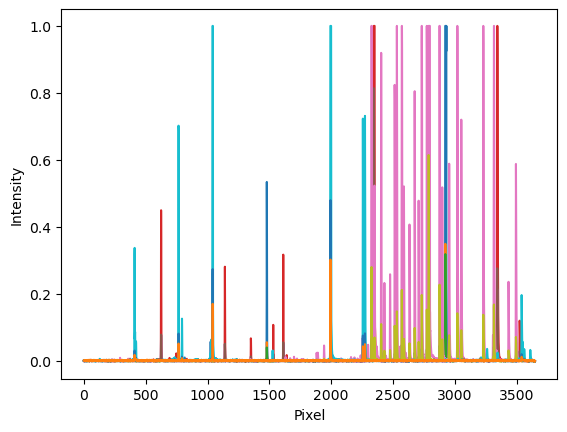

In [6]:
for el in elementsData: # el is a str, looping through each of the keys in elementsData
    for dat in elementsData[el]: # accesses the 2D array for given element key el, looping through each position
        plt.plot(range(len(dat)), dat) # plotting to show that accessing the data in this way results in the array dat being the expected 1xn array of intensities

plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.show()

In [7]:
print(np.shape(elementsData['hydrogen']))

(3, 3648)


### Centroid function example

2927.2200827712995


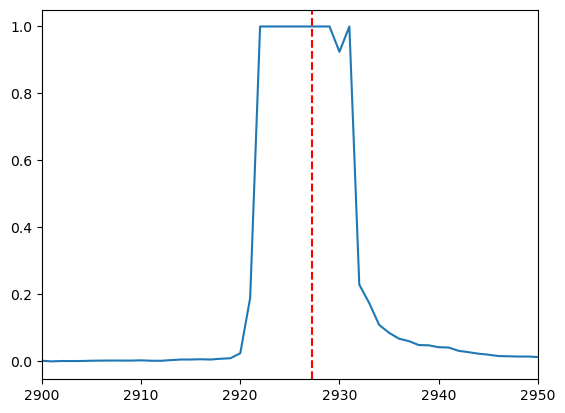

In [26]:
plt.plot(range(len(elementsData['hydrogen'][0])), elementsData['hydrogen'][0])
cen = centroid(elementsData['hydrogen'][0],(2900,2950)) # using the optional bounds parameter to find the centroid of the emission line between pixels 2900 and 2950
print(cen)
plt.axvline(cen, color='red', linestyle='--')
plt.xlim(2900, 2950)
plt.show()

### Fitting function example

Text(5, 15, 'm = 0.976\nc = 0.347')

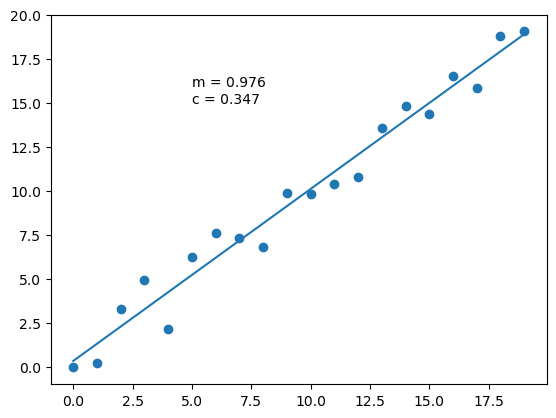

In [40]:
m = 1
c = 0

x = np.arange(20, dtype=float)
#np.random.seed(1)
y = m*x + c + np.random.randn(20)

mfit, cfit = leastSquaresFit(x,y)

plt.scatter(x, y)
plt.plot(x, mfit*x + cfit)
plt.text(5,15,'m = {:.3f}\nc = {:.3f}'.format(mfit,cfit))